# Downscaling Temperature at 2m for the **NYC/Tristate** area

**Variables:**
* Variable to be downscaled: Temperature at 2 meters (T2)
* Predictor variable: Surface Pressure (PSFC) 

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 127719.4 km²

In [6]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [7]:
!python --version

Python 3.8.18


# Retrieve files from server

In [8]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/train/uWRF_final_01-02.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/val/uWRF_final_03.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/test/uWRF_final_03.nc')

nam_train = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/home/gvaillant1/downscaling/data/T2-tristate-data/aligned_nam_test_data.nc')

# Calculating Spatial Coverage:

In [9]:
import xarray as xr
import numpy as np
from geopy.distance import geodesic

# Load the dataset
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/pred-split/train/uWRF_final_01-02.nc')

# Extract latitude and longitude
lat = uwrf_train['latitude'].values  # Assuming 'latitude' is the name of the dimension
lon = uwrf_train['longitude'].values  # Assuming 'longitude' is the name of the dimension

# Compute the distance between two adjacent latitude points (in km)
lat_diff = np.abs(lat[1] - lat[0])  # Difference between two adjacent latitude points
lat_distance_km = lat_diff * 111  # 1 degree of latitude ~ 111 km

# Compute the distance between two adjacent longitude points (in km)
lon_diff = np.abs(lon[1] - lon[0])  # Difference between two adjacent longitude points
lon_distance_km = lon_diff * 111 * np.cos(np.radians(lat[0]))  # Adjust for latitude

# Calculate the area of one grid cell (in km²)
cell_area_km2 = lat_distance_km * lon_distance_km

# Calculate the total area covered by the dataset (in km²)
num_lat_cells = len(lat)
num_lon_cells = len(lon)
total_area_km2 = num_lat_cells * num_lon_cells * cell_area_km2

# Output the total area
print(f"Total area covered by the dataset: {total_area_km2} km²")


Total area covered by the dataset: 127719.36513031229 km²


# Accessing specific variable from each dataset

In [10]:
#High resolution (uWRF) data
T2_hr_train = uwrf_train.T2
T2_hr_val = uwrf_val.T2
T2_hr_test = uwrf_test.T2

PSFC_hr_train = uwrf_train.PSFC
PSFC_hr_val = uwrf_val.PSFC
PSFC_hr_test = uwrf_test.PSFC
#--------------------------
#Low resolution (NAM) data
T2_lr_train = nam_train.T2
T2_lr_val = nam_val.T2
T2_lr_test = nam_test.T2

PSFC_lr_train = nam_train.PSFC
PSFC_lr_val = nam_val.PSFC
PSFC_lr_test = nam_test.PSFC

# Normalization:

In [11]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)


In [12]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

y_z_train = y_z_train.expand_dims(dim ='channel', axis=-1)
y_z_val = y_z_val.expand_dims(dim ='channel', axis=-1)
y_z_test = y_z_test.expand_dims(dim ='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)

x_z_train = x_z_train.expand_dims(dim ='channel', axis=-1)
x_z_val = x_z_val.expand_dims(dim ='channel', axis=-1)
x_z_test = x_z_test.expand_dims(dim ='channel', axis=-1)

In [13]:
print("T2 hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")
print("PSFC hr data shape:")
print(y_z_train.shape, y_z_val.shape, y_z_test.shape)
print("")
print("T2 lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)
print("")
print("PSFC lr data shape:")
print(x_z_train.shape, x_z_val.shape, x_z_test.shape)

T2 hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

PSFC hr data shape:
(1537, 120, 120, 1) (870, 120, 120, 1) (870, 120, 120, 1)

T2 lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)

PSFC lr data shape:
(1537, 30, 30, 1) (450, 30, 30, 1) (450, 30, 30, 1)


HR array: (120, 120, 1), LR array (30, 30, 2)


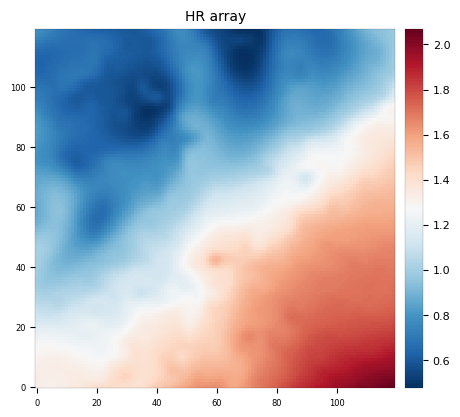

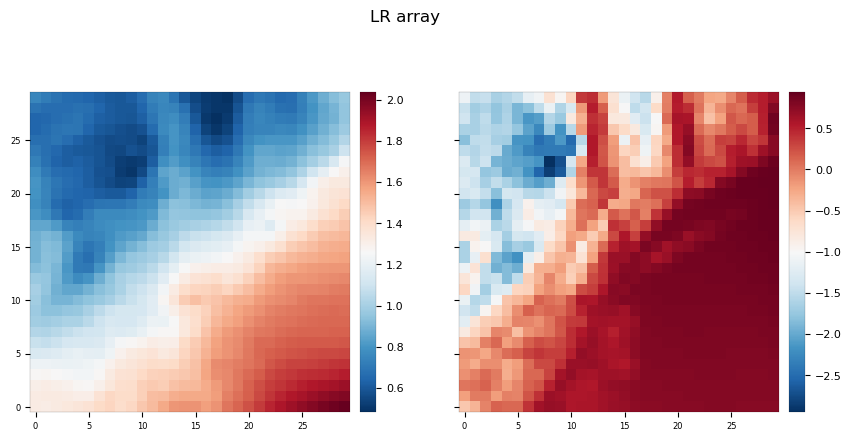

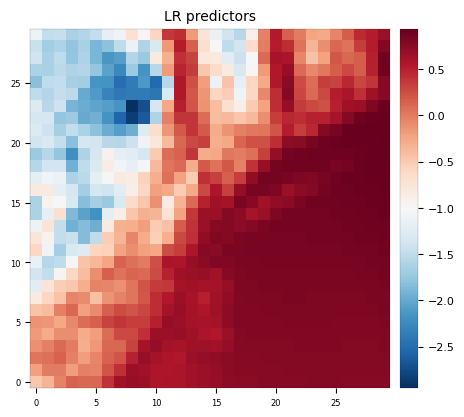

In [14]:
#Check for correct creation of the low-res version of uWRF
#This function is called before training begins. This is just an example to show what is going on:

_ = dds.create_pair_hr_lr(y_train.values[0], None, 'spc', 4, None, None, y_z_train.values[0], None, True, interpolation='inter_area')

# Training Model

There are several types of backbones to try, so here we will implement each one and evaluate which performs best.

* resnet
* densenet
* convnet
* convnext

In [ ]:
ARCH_PARAMS = dict(n_filters=8,
                   n_blocks=8,
                   normalization=None,
                   dropout_rate=0.0,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='resnet',
    upsampling='spc', 
    data_train=y_train,
    data_val=y_val,
    data_test=y_test,
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train],
    predictors_val=[y_z_val],
    predictors_test=[y_z_test],
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60, #changed from 60
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()


List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-01-15 16:47:26
--------------------------------------------------------------------------------
Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_1 (InputLayer)                        [(None, None, None, 2)]                      0              []                                           
                                                                                                                                                      
 conv2d (Conv2D)                             (None, 

# Prediction on unseen uWRF test set

In [ ]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=[y_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=64,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

# Prediction on unseen NAM test set

In [ ]:
pred1 = dds.Predictor(
    trainer, 
    x_test, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=[x_z_test], 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=T2_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

In [ ]:
unscaled_y_test = T2_scaler_train.inverse_transform(y_test)

# Compare training results with the ground truth data (uWRF)

In [ ]:
ecv.plot((unscaled_y_test[1].values, unscaled_y_pred[1]), subplot_titles=('groundtruth t2m', 'downscaled t2m'))

mae = dds.losses.mae(unscaled_y_test[1].values, unscaled_y_pred[1])
print(f"MAE for training: {mae}")

# Compare results with the original NAM data

In [ ]:
unscaled_x_test = T2_scaler_train.inverse_transform(x_test)
ecv.plot((unscaled_x_test[1].values, unscaled_x_pred[1]), subplot_titles=('original t2m (NAM)', 'downscaled t2m'))

# Compare results with ground truth data (uWRF)

In [ ]:
ecv.plot((unscaled_y_test[1].values, unscaled_x_pred[1]), subplot_titles=('ground truth t2m (uWRF)', 'downscaled t2m'))

# Coarsened variables (done during training process)

In [ ]:
ind = 1
ecv.plot((coarsened_array1[ind][:,:,0], coarsened_array1[ind][:,:,1]), subplot_titles=('t2m coarsened', 'PSFC (predictor) coarsened'))

In [ ]:
mae = dds.losses.mae(unscaled_y_test.values[1], unscaled_y_pred[1])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")

